In [64]:
# Energy Forecasting with GRU - Jupyter Notebook Version

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from google.colab import files
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, LSTM, Dense
from tensorflow.keras.optimizers import Adam # Import Adam optimizer

In [65]:
uploaded = files.upload()
df=pd.read_csv(list(uploaded.keys())[0],sep=',') #carga el dataset (en CSV) desde el pc en un dataframe de pandas

Saving Consumo Energetico Pereira.csv to Consumo Energetico Pereira.csv


In [66]:
'''
df['Date'] = pd.to_datetime(df['Date'],format='%d/%m/%Y %H:%M')
#df['Date'] = pd.to_datetime(df['Date'],format='%d/%m/%Y')
df['DayOfWeek'] = df['Date'].dt.dayofweek
df['Day'] = df['Date'].dt.day
df['Month'] = df['Date'].dt.month
df['Year'] = df['Date'].dt.year
df['Hour'] = df['Date'].dt.hour
'''

features = ['Hour', 'DayOfWeek', 'Day', 'Month', 'Year']


X = df[features].values
Y = df[['Consumo']].values


# Scale features and target
scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()

X_scaled = scaler_x.fit_transform(X)
y_scaled = scaler_y.fit_transform(Y)

# Create sequences for time series data
sequence_length = 24 # Number of past time steps to consider

def create_sequences(X, y, seq_length):
    X_seq, y_seq = [], []
    for i in range(len(X) - seq_length):
        X_seq.append(X[i:i+seq_length])
        y_seq.append(y[i+seq_length])
    return np.array(X_seq), np.array(y_seq)

X_seq, y_seq = create_sequences(X_scaled, y_scaled, sequence_length)



# Split data into training and testing sets
train_size = int(0.7 * len(X_seq))
X_train, X_test = X_seq[:train_size], X_seq[train_size:]
y_train, y_test = y_seq[:train_size], y_seq[train_size:]

# Print shapes to verify the split
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (119126, 24, 5)
y_train shape: (119126, 1)
X_test shape: (51055, 24, 5)
y_test shape: (51055, 1)



Training GRU Model...
Epoch 1/10
3351/3351 ━━━━━━━━━━━━━━━━━━━━ 106s 30ms/step - loss: 0.0065 - val_loss: 0.0050
Epoch 2/10
3351/3351 ━━━━━━━━━━━━━━━━━━━━ 142s 30ms/step - loss: 0.0023 - val_loss: 0.0027
Epoch 3/10
3351/3351 ━━━━━━━━━━━━━━━━━━━━ 145s 31ms/step - loss: 0.0020 - val_loss: 0.0019
Epoch 4/10
3351/3351 ━━━━━━━━━━━━━━━━━━━━ 140s 31ms/step - loss: 0.0017 - val_loss: 0.0023
Epoch 5/10
3351/3351 ━━━━━━━━━━━━━━━━━━━━ 102s 30ms/step - loss: 0.0016 - val_loss: 0.0018
Epoch 6/10
3351/3351 ━━━━━━━━━━━━━━━━━━━━ 142s 31ms/step - loss: 0.0016 - val_loss: 0.0020
Epoch 7/10
3351/3351 ━━━━━━━━━━━━━━━━━━━━ 144s 31ms/step - loss: 0.0015 - val_loss: 0.0019
Epoch 8/10
3351/3351 ━━━━━━━━━━━━━━━━━━━━ 142s 31ms/step - loss: 0.0014 - val_loss: 0.0019
Epoch 9/10
3351/3351 ━━━━━━━━━━━━━━━━━━━━ 140s 31ms/step - loss: 0.0013 - val_loss: 0.0021
Epoch 10/10
3351/3351 ━━━━━━━━━━━━━━━━━━━━ 141s 30ms/step - loss: 0.0013 - val_loss: 0.0018


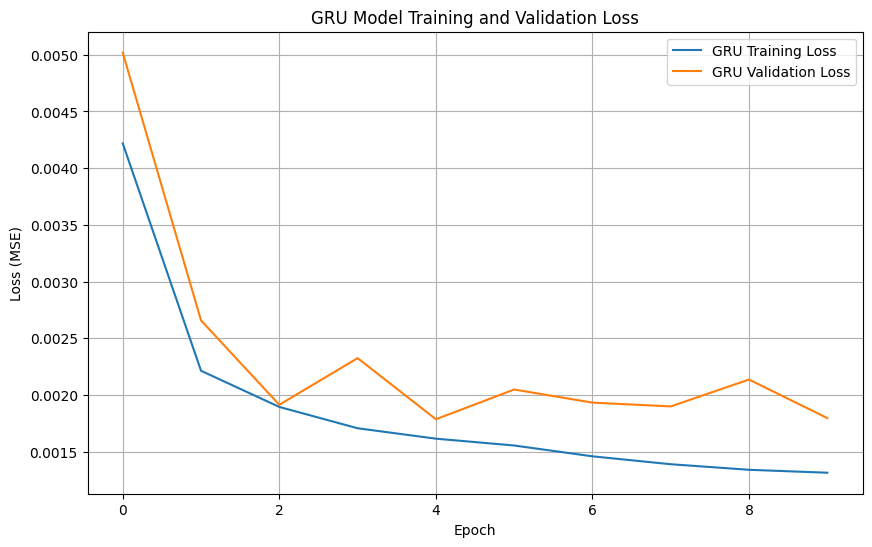


Evaluating GRU Model...
GRU Test Loss (MSE): 0.0012
1596/1596 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step


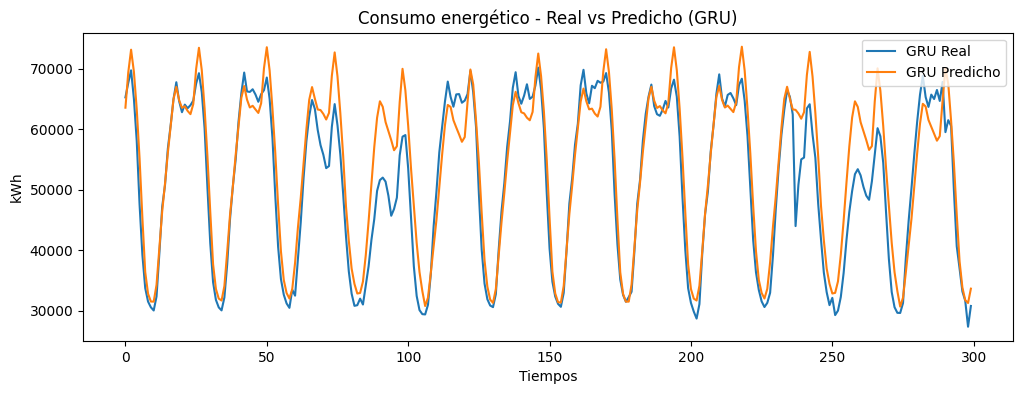


GRU Model Results:
MAE: 4208.6416
MSE: 29241764.3818
R2 Score: 0.8461


In [67]:
## GRU Model

# GRU Model Definition
def create_gru_model(input_shape):
    model = Sequential()
    # Input layer with the correct shape (sequence_length, num_features)
    model.add(tf.keras.layers.Input(shape=input_shape))
    # GRU layers with return_sequences=True for all but the last GRU layer
    model.add(GRU(64, return_sequences=True, dropout=0.2))
    model.add(GRU(64, dropout=0.2)) # Last GRU layer should not return sequences
    # Dense output layer
    model.add(Dense(1))
    # Compile the model
    model.compile(optimizer=Adam(0.001), loss='mse')
    return model

# Create and Train GRU model
# Pass the input shape dynamically based on the processed data
gru_model = create_gru_model(input_shape=(sequence_length, X_train.shape[2]))
print("\nTraining GRU Model...")
gru_history = gru_model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32,
    validation_split=0.1, # Use 10% of training data for validation
    verbose=1
)

# Plot training and validation loss for GRU
plt.figure(figsize=(10, 6))
plt.plot(gru_history.history['loss'], label='GRU Training Loss')
plt.plot(gru_history.history['val_loss'], label='GRU Validation Loss')
plt.title('GRU Model Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.show()


# Evaluate GRU model
print("\nEvaluating GRU Model...")
gru_loss = gru_model.evaluate(X_test, y_test, verbose=0) # verbose=0 to avoid detailed output during evaluation
print(f"GRU Test Loss (MSE): {gru_loss:.4f}")

gru_preds = gru_model.predict(X_test)

# Inverse transform predictions and actuals for GRU
gru_preds_original_scale = scaler_y.inverse_transform(gru_preds)
gru_actuals_original_scale = scaler_y.inverse_transform(y_test)


# Visualize GRU results (first 300 points)
plt.figure(figsize=(12, 4))
plt.plot(gru_actuals_original_scale[:300], label="GRU Real")
plt.plot(gru_preds_original_scale[:300], label="GRU Predicho")
plt.title("Consumo energético - Real vs Predicho (GRU)")
plt.xlabel("Tiempos")
plt.ylabel("kWh")
plt.legend()
plt.show()

# Calculate GRU metrics
gru_mae = mean_absolute_error(gru_actuals_original_scale, gru_preds_original_scale)
gru_mse = mean_squared_error(gru_actuals_original_scale, gru_preds_original_scale)
# Ensure r2_score doesn't receive a single value array for actuals
if gru_actuals_original_scale.ndim > 1 and gru_actuals_original_scale.shape[1] > 1:
    gru_r2 = r2_score(gru_actuals_original_scale, gru_preds_original_scale)
else:
     # Reshape if necessary, assuming actuals is a 1D array or a column vector
     gru_r2 = r2_score(gru_actuals_original_scale.flatten(), gru_preds_original_scale.flatten())


print("\nGRU Model Results:")
print(f"MAE: {gru_mae:.4f}")
print(f"MSE: {gru_mse:.4f}")
print(f"R2 Score: {gru_r2:.4f}")


Training LSTM Model...
Epoch 1/10
3351/3351 ━━━━━━━━━━━━━━━━━━━━ 92s 26ms/step - loss: 0.0052 - val_loss: 0.0017
Epoch 2/10
3351/3351 ━━━━━━━━━━━━━━━━━━━━ 142s 26ms/step - loss: 0.0024 - val_loss: 0.0027
Epoch 3/10
3351/3351 ━━━━━━━━━━━━━━━━━━━━ 87s 26ms/step - loss: 0.0018 - val_loss: 0.0023
Epoch 4/10
3351/3351 ━━━━━━━━━━━━━━━━━━━━ 143s 26ms/step - loss: 0.0016 - val_loss: 0.0018
Epoch 5/10
3351/3351 ━━━━━━━━━━━━━━━━━━━━ 141s 26ms/step - loss: 0.0015 - val_loss: 0.0015
Epoch 6/10
3351/3351 ━━━━━━━━━━━━━━━━━━━━ 143s 26ms/step - loss: 0.0014 - val_loss: 0.0026
Epoch 7/10
3351/3351 ━━━━━━━━━━━━━━━━━━━━ 140s 26ms/step - loss: 0.0013 - val_loss: 0.0021
Epoch 8/10
3351/3351 ━━━━━━━━━━━━━━━━━━━━ 140s 25ms/step - loss: 0.0013 - val_loss: 0.0018
Epoch 9/10
3351/3351 ━━━━━━━━━━━━━━━━━━━━ 85s 25ms/step - loss: 0.0013 - val_loss: 0.0019
Epoch 10/10
3351/3351 ━━━━━━━━━━━━━━━━━━━━ 141s 25ms/step - loss: 0.0013 - val_loss: 0.0018


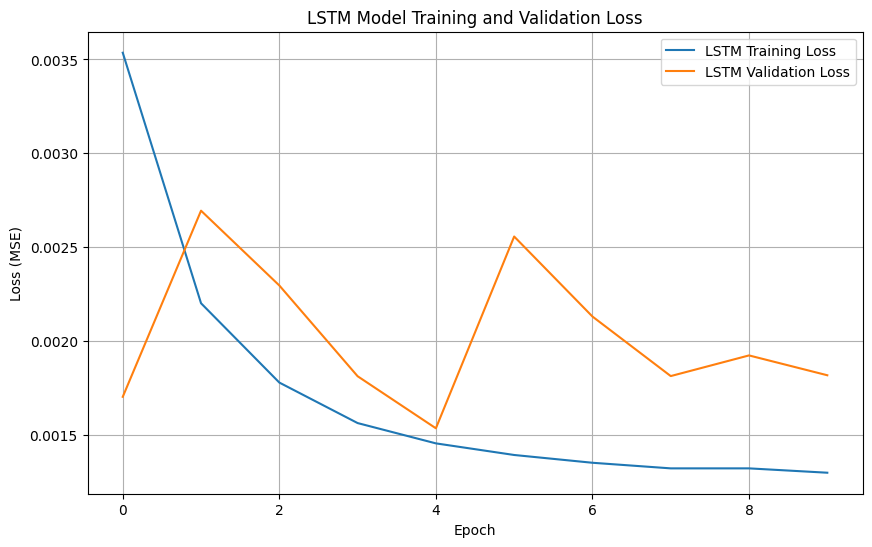


Evaluating LSTM Model...
LSTM Test Loss (MSE): 0.0012
1596/1596 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step


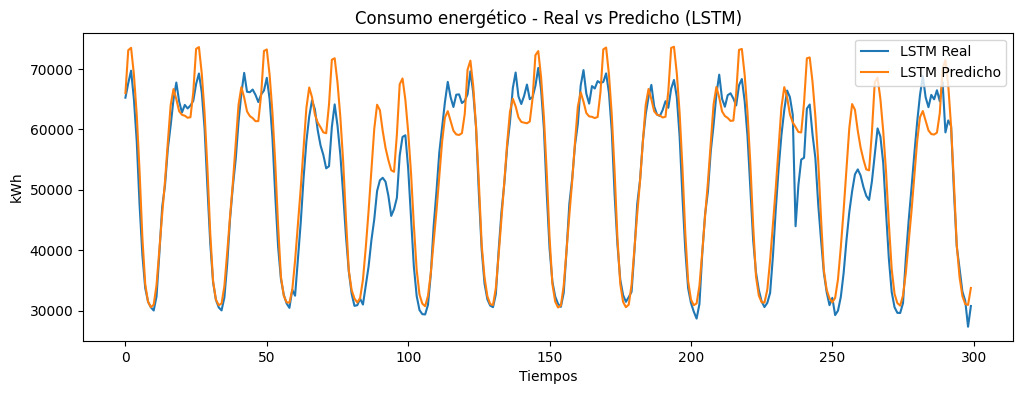


LSTM Model Results:
MAE: 4164.4500
MSE: 28157684.5243
R2 Score: 0.8518


In [68]:
## LSTM Model

# LSTM Model Definition
def create_lstm_model(input_shape):
    model = Sequential()
    # Input layer with the correct shape
    model.add(tf.keras.layers.Input(shape=input_shape))
    # LSTM layers
    model.add(LSTM(64, return_sequences=True, dropout=0.2))
    model.add(LSTM(64, dropout=0.2)) # Last LSTM layer should not return sequences
    # Dense output layer
    model.add(Dense(1))
    # Compile the model
    model.compile(optimizer=Adam(0.001), loss='mse')
    return model

# Create and Train LSTM model
# Pass the input shape dynamically
lstm_model = create_lstm_model(input_shape=(sequence_length, X_train.shape[2]))
print("\nTraining LSTM Model...")
lstm_history = lstm_model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32,
    validation_split=0.1, # Use 10% of training data for validation
    verbose=1
)

# Plot training and validation loss for LSTM
plt.figure(figsize=(10, 6))
plt.plot(lstm_history.history['loss'], label='LSTM Training Loss')
plt.plot(lstm_history.history['val_loss'], label='LSTM Validation Loss')
plt.title('LSTM Model Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.show()


# Evaluate LSTM model
print("\nEvaluating LSTM Model...")
lstm_loss = lstm_model.evaluate(X_test, y_test, verbose=0)
print(f"LSTM Test Loss (MSE): {lstm_loss:.4f}")

lstm_preds = lstm_model.predict(X_test)

# Inverse transform predictions and actuals for LSTM
lstm_preds_original_scale = scaler_y.inverse_transform(lstm_preds)
lstm_actuals_original_scale = scaler_y.inverse_transform(y_test)

# Visualize LSTM results (first 300 points)
plt.figure(figsize=(12, 4))
plt.plot(lstm_actuals_original_scale[:300], label="LSTM Real")
plt.plot(lstm_preds_original_scale[:300], label="LSTM Predicho")
plt.title("Consumo energético - Real vs Predicho (LSTM)")
plt.xlabel("Tiempos")
plt.ylabel("kWh")
plt.legend()
plt.show()

# Calculate LSTM metrics
lstm_mae = mean_absolute_error(lstm_actuals_original_scale, lstm_preds_original_scale)
lstm_mse = mean_squared_error(lstm_actuals_original_scale, lstm_preds_original_scale)
# Ensure r2_score doesn't receive a single value array for actuals
if lstm_actuals_original_scale.ndim > 1 and lstm_actuals_original_scale.shape[1] > 1:
     lstm_r2 = r2_score(lstm_actuals_original_scale, lstm_preds_original_scale)
else:
     # Reshape if necessary
     lstm_r2 = r2_score(lstm_actuals_original_scale.flatten(), lstm_preds_original_scale.flatten())


print("\nLSTM Model Results:")
print(f"MAE: {lstm_mae:.4f}")
print(f"MSE: {lstm_mse:.4f}")
print(f"R2 Score: {lstm_r2:.4f}")

In [69]:
# prompt: guardar los dos modelos lstm y gru

# Save the trained models
gru_model.save('gru_energy_model.h5')
lstm_model.save('lstm_energy_model.h5')

print("\nModels saved successfully!")
print("GRU model saved as: gru_energy_model.h5")
print("LSTM model saved as: lstm_energy_model.h5")



Models saved successfully!
GRU model saved as: gru_energy_model.h5
LSTM model saved as: lstm_energy_model.h5
